# CaseCreation_KingPlains functionality
- Takes King Plains turbine locations supplied in KingPlainsTurbineLocations.CSV
- Rotates the points 90 degrees clockwise to match TurbSim directional convention
- Reads KingPlainsDirectionSweepInfo.csv to determine inflow directions
- Rotates turbines through each yaw direction to determine maximum extents of domain
- Determines T1, T2, T3 X and Y locations
- Creates a ParamValues file:  (TI, Vhub and Shear) and T1-T3 X and Y locations
- Loads ParamValues file and creates TurbSim files
-- Benchmark File with short run duration
-- Full File with required duration



In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import subprocess
from os import walk
import shutil
import itertools

from InputSetup import FFInputCreation as inputCreation
from ParameterManipulation import createTSParamFiles, createFFParamFiles, copyNominalFiles
from stochasticTurbulenceTools_mod import stochasticTurbulence

#### Define Input Paramters. If # of seeds does not apply, can set to one or modify other parts of this script to remove it.

In [3]:
nSeeds = 6
HubHt = 88.5
D=127
t_benchmark = 5  # Seconds -> Short run duration to test TurbSim files
t_desired = 3600 # Seconds -> Default: One Hour
t_step = 3
fmax = 5
cmax=50
dir_convention = '0 West' # Directional convention. Will rotate turbine layouts supplied if 

# u_ref_options = np.arange(3, 26, 0.5).tolist()
# ti_options = list(range(0, 31))
# shear_options = np.arange(0.01, 0.07, 0.01).tolist()

In [4]:
workdir='/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/'
os.chdir(workdir)

### Load Turbine Locations

In [5]:
turblocs= pd.read_csv('KingPlainsTurbineLocations.csv',header=1)
xlocs_OG = turblocs.x_rotated
ylocs_OG = turblocs.y_rotated
nTurbs = len(xlocs_OG)

In [6]:
turblocs

,Turbine#,x_rotated,y_rotated,z
0,0,19678.4069,7386.65328,0
1,1,17497.0140,11177.42380,0
2,2,22045.8782,6393.54067,0
3,3,19039.2543,10213.55400,0
4,4,18326.2961,11129.18130,0
5,5,16881.7469,9169.15472,0
6,6,17580.4701,6115.94876,0
7,7,17872.2194,11062.49030,0
8,8,18164.6694,9130.29568,0
9,9,18574.0937,9127.64773,0


### Plot the Turbine Locations

Text(0.5, 1.0, 'Turbine Locations with default orientation')

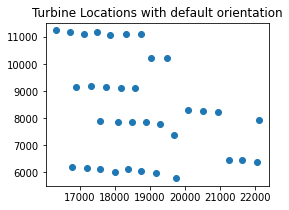

In [7]:
fig = plt.figure(figsize=(4,3))
plt.scatter(xlocs_OG,ylocs_OG)
plt.title('Turbine Locations with default orientation')

### Rotate the turbines to match directional convention

In [8]:
r=np.zeros(nTurbs)

for turb in range(nTurbs):
    r[turb] = np.sqrt(xlocs_OG[turb]**2+ylocs_OG[turb]**2)
    
if dir_convention == '0 West':
    theta = -90

xlocs_rot = list()
ylocs_rot = list()
print(nTurbs)
for turb in range(nTurbs):
#     print("Turb: {}".format(turb))
#     print("X loc: {}".format(xlocs_OG[turb]))
#     print("Y loc: {}".format(ylocs_OG[turb]))
    if xlocs_OG[turb] != 0:
        theta_rot = np.arctan(ylocs_OG[turb]/xlocs_OG[turb])+np.radians(theta)
        ylocs_rot.append(r[turb]*np.sin(theta_rot))
        xlocs_rot.append(r[turb]*np.cos(theta_rot))
#         print("Theta Rot: {}".format(theta_rot))
#         print("X loc rotated: {}".format(xlocs_rot[turb]))
#         print("Y loc rotated: {}".format(ylocs_rot[turb]))
        


35


Text(8422.193392857143, -19042.18400285714, 'Centroid')

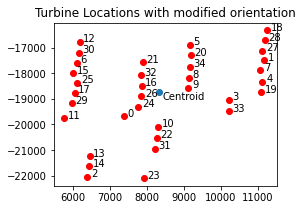

In [9]:
# Plot the rotated points
fig = plt.figure(figsize=(4,3))
plt.scatter(xlocs_rot,ylocs_rot,color='red')
for i in range(len(xlocs_rot)):
    plt.annotate(i, (xlocs_rot[i] + 100, ylocs_rot[i]))
plt.title('Turbine Locations with modified orientation')

# Determine the Centroid
centroid = (sum(xlocs_rot) / len(xlocs_rot), sum(ylocs_rot) / len(xlocs_rot))
plt.scatter(centroid[0],centroid[1])
# print(centroid[0])
plt.annotate("Centroid", (centroid[0]+100, centroid[1]-300))

In [10]:
# Center the points around 0,0
xlocs_centered = list()
ylocs_centered = list()
centroid_x = centroid[0]
centroid_y = centroid[1]
dist_centroid_to_min_x = centroid_x - min(xlocs_rot)
print(dist_centroid_to_min_x)
for turb in range(nTurbs):
#     if xlocs_rot[turb] != 0:
        xlocs_centered.append(xlocs_rot[turb] - (centroid_x-dist_centroid_to_min_x))
        ylocs_centered.append(ylocs_rot[turb] - centroid_y)


2550.111002857144


Text(0.5, 1.0, 'Turbine Locations Rotated and Centered')

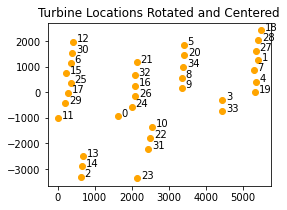

In [11]:
# Plot the centered (and rotated) points

fig = plt.figure(figsize=(4,3))
plt.scatter(xlocs_centered,ylocs_centered,color='orange')
for i in range(len(xlocs_centered)):
    plt.annotate(i, (xlocs_centered[i] + 100, ylocs_centered[i]))
plt.title('Turbine Locations Rotated and Centered')

### Load Directional Sweep info to determine domain rotations


In [12]:
Yaw = pd.read_csv('KingPlainsDirectionSweepInfo.csv', header=None,index_col=0,delimiter=',')
nCases = int(Yaw.shape[1])
caseNames=['None']*nCases
for case in range(nCases):
    caseNames[int(case)] = 'Case_{0}'.format(case)
    
    
Yaw.columns=caseNames

In [13]:
Yaw

,Case_0,Case_1,Case_2,Case_3,Case_4,Case_5
0,,,,,,
WindDir,-15,-10,0,5,10,15
Misalignment,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE
WakeSteer,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


### Rotate the layout for each yaw angle case and determine max domain extents

In [14]:
ylocs_new = {case:{turb:{} for turb in range(nTurbs)}for case in range(nCases)}
xlocs_new = {case:{turb:{} for turb in range(nTurbs)}for case in range(nCases)}

for turb in range(nTurbs):
    r[turb] = np.sqrt(xlocs_centered[turb]**2+ylocs_centered[turb]**2)
#     r[turb] = np.sqrt(xlocs_rot[turb]**2+ylocs_rot[turb]**2)
for index,case in enumerate(caseNames):
    theta = np.float(Yaw[case]['WindDir'])
    ylocs_new[index][0]=0
    xlocs_new[index][0]=0
    for turb in range(nTurbs):
        if xlocs_centered[turb] != 0:
            theta_rot = np.arctan(ylocs_centered[turb]/xlocs_centered[turb])+np.radians(theta)
            ylocs_new[index][turb] = r[turb]*np.sin(theta_rot)
            xlocs_new[index][turb] = r[turb]*np.cos(theta_rot)
        if xlocs_centered[turb] == 0:
            theta_rot = 0
            ylocs_new[index][turb] = ylocs_centered[turb]
            xlocs_new[index][turb] = xlocs_centered[turb]
            
          
#     xoff = min(xlocs_new[index].values())
#     for turb in range(nTurbs):
#         print(xlocs_new[index][turb])
#         xlocs_new[index][turb]=xlocs_new[index][turb]-xoff   
# print(xlocs_centered)

### Plot the layouts for validation and determine new x and y min and max values

-254.77637480207105
0.0
0.0
0.0
0.0
-107.0985462022368


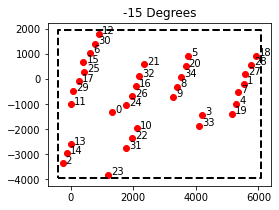

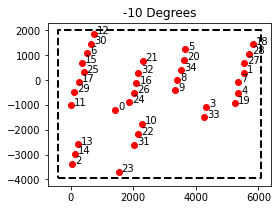

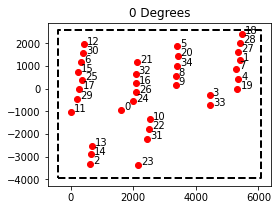

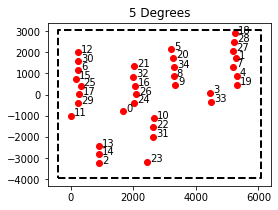

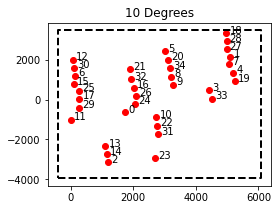

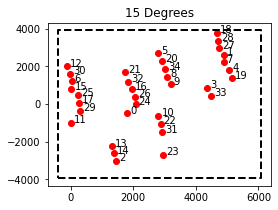

In [15]:
x_min_new = 5000
x_max_new = 0
y_min_new = 0
y_max_new = 0
for index,case in enumerate(caseNames):
    fig = plt.figure(figsize=(4,3))

    plt.scatter(xlocs_new[index].values(),ylocs_new[index].values(),color='red')
    plt.title(Yaw[case].WindDir + " Degrees")
    for i in range(len(xlocs_new[index])):
        plt.annotate(i, (xlocs_new[index][i] + 100, ylocs_new[index][i]))
    #Determine new absolute mins and maxes for x and y coords
    x_min = min(xlocs_new[index].values())
    print(x_min)
    x_max = max(xlocs_new[index].values())
    y_min = min(ylocs_new[index].values())
    y_max = max(ylocs_new[index].values())
    
    if x_min < x_min_new:
        x_min_new = x_min
    if x_max > x_max_new:
        x_max_new = x_max
    if y_min < y_min_new:
        y_min_new = y_min
    if y_max > y_max_new:
        y_max_new = y_max
        
    plt.plot([x_min_new-150,x_max_new+150,x_max_new+150,x_min_new-150,x_min_new-150],
    [y_min_new-150,y_min_new-150,y_max_new+150,y_max_new+150,y_min_new-150],'--k',lw=2,label='Low')


### Print the new min and max X and Y values

In [16]:
# Max, Min X and Y values
print("New minimum X Value is: {}".format(x_min_new))
print("New maximum X Value is: {}".format(x_max_new))
print("New minimum Y Value is: {}".format(y_min_new))
print("New maximum Y Value is: {}".format(y_max_new))

New minimum X Value is: -254.77637480207105
New maximum X Value is: 5924.331132015654
New minimum Y Value is: -3807.7573951497793
New maximum Y Value is: 3765.9099512565563


### Print the expected width and height

In [17]:
x_span = x_max_new - x_min_new
y_span = y_max_new - y_min_new
print("X Span is: {}".format(x_span))
print("Y Span is: {}".format(y_span))

X Span is: 6179.107506817724
Y Span is: 7573.667346406335


### Take these max and min y locations and create a T1, T2, T3 x and y set of coordinates

In [18]:
T1_xloc = 0
T1_yloc = 0

# Translate other y coords by the amount that T1_yloc was translated for consistency
T2_xloc = x_span
T2_yloc = y_span/2
T3_xloc = x_span
T3_yloc = -y_span/2

### Create ParamValues file (including TI, Vhub, Shear, and X/Y Coords)

In [19]:
ParamVals = pd.read_csv(os.path.join(workdir,'SampleFiles/ParamValues_KingPlains_Base.csv'), header=None,index_col=0,delimiter=',')
# ParamVals[0] = T1_xloc
for i in range(1,4):
    ParamVals[i][3] = T1_xloc
    ParamVals[i][4] = T1_yloc
    ParamVals[i][5] = T2_xloc
    ParamVals[i][6] = T2_yloc
    ParamVals[i][7] = T3_xloc
    ParamVals[i][8] = T3_yloc
# ParamVals.reset_index(drop=True,inplace=True)
#ParamVals.set_index('0')
ParamVals.to_csv(os.path.join(workdir,'SampleFiles/ParamValues_KingPlains_Updated.csv'))

In [20]:
ParamVals

,1,2,3
0,,,
TI,0.150000,0.160000,0.170000
Vhub,6.000000,7.000000,8.000000
Shear,0.050000,0.050000,0.050000
T1x-locs,0.000000,0.000000,0.000000
T1y-locs,0.000000,0.000000,0.000000
T2x-locs,6179.107507,6179.107507,6179.107507
T2y-locs,3786.833673,3786.833673,3786.833673
T3x-locs,6179.107507,6179.107507,6179.107507
T3y-locs,-3786.833673,-3786.833673,-3786.833673


### Create cases based on ranges or discrete values?

In [21]:
Ranges = False

### Read in case parameters

In [22]:
if Ranges == False:
    ParamVals = pd.read_csv(os.path.join(workdir,'SampleFiles/ParamValues_KingPlains_Updated.csv'), header=0,index_col=0,delimiter=',')
    nTurbs = int(ParamVals.shape[0]/3)
    nCases = int(ParamVals.shape[1])
else:
    #writeParamVals()
    OrigVals = pd.read_csv(os.path.join(workdir,'SampleFiles/ParamRanges_KingPlains.csv'), names=['Var','MinVar','MaxVar','NomVar'])
    OrigVals = OrigVals['NomVar']

In [23]:
ParamVals

,1,2,3
0,,,
TI,0.150000,0.160000,0.170000
Vhub,6.000000,7.000000,8.000000
Shear,0.050000,0.050000,0.050000
T1x-locs,0.000000,0.000000,0.000000
T1y-locs,0.000000,0.000000,0.000000
T2x-locs,6179.107507,6179.107507,6179.107507
T2y-locs,3786.833673,3786.833673,3786.833673
T3x-locs,6179.107507,6179.107507,6179.107507
T3y-locs,-3786.833673,-3786.833673,-3786.833673


##### Detect the number of turbines in the simulation; this will have to be modified based on your input file

In [24]:
nTurbs=int(ParamVals[3:].shape[0]/2)
print("nTurbs:", nTurbs)

nTurbs: 3


In [25]:
nCases=ParamVals.shape[1]
print("nCases:", nCases)

nCases: 3


### Create Case Directory Structure

In [26]:
caseNames=['None']*nCases
for case in range(nCases):
    if case < 10:
        case = '0'+str(case)
    caseNames[int(case)] = 'Case{0}'.format(case)
    
ParamVals.columns=caseNames
ParamVals

,Case00,Case01,Case02
0,,,
TI,0.150000,0.160000,0.170000
Vhub,6.000000,7.000000,8.000000
Shear,0.050000,0.050000,0.050000
T1x-locs,0.000000,0.000000,0.000000
T1y-locs,0.000000,0.000000,0.000000
T2x-locs,6179.107507,6179.107507,6179.107507
T2y-locs,3786.833673,3786.833673,3786.833673
T3x-locs,6179.107507,6179.107507,6179.107507
T3y-locs,-3786.833673,-3786.833673,-3786.833673


### This section creates the directory structure and copies any nominal files from a specified directory to all directories created here. This will have to be modified based on the directory structure you want and the files you want to copy

In [27]:
os.chdir(workdir)
os.getcwd()

# #Create Benchmark case first
# name1 = 'Benchmark'
# if not os.path.exists(name1):
#     os.makedirs(name1)
# os.chdir(name1)
# print(os.getcwd())
# copyNominalFiles(nSeeds,nTurbs)
# os.chdir('..')  
# os.chdir(workdir)

#Now create parameterized cases
for case in range(nCases):
    name1=caseNames[case]
    if not os.path.exists(name1):
        os.makedirs(name1)
    os.chdir(name1)
    print(os.getcwd())
    copyNominalFiles(nSeeds,nTurbs)
    os.chdir('..')
os.chdir(workdir)

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_0
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_1
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_2
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_3
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_4
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_5
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case01
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case01/Seed_0
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case01/Seed_1
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case01/Seed_2
/Users/abarker/Desktop/AWAKEN/FAST/

# Create TurbSim Files (Benchmark and Full-Duration)

## The following command creates the .inp files for the low- and high-resolution domains, as well as a .inp file for each turbine in the simulation.

Creating TurbSim files with the following parameters:
caseNames: ['Case00', 'Case01', 'Case02']
nSeeds: 6
ParamVals:                Case00       Case01       Case02
0                                              
TI           0.150000     0.160000     0.170000
Vhub         6.000000     7.000000     8.000000
Shear        0.050000     0.050000     0.050000
T1x-locs     0.000000     0.000000     0.000000
T1y-locs     0.000000     0.000000     0.000000
T2x-locs  6179.107507  6179.107507  6179.107507
T2y-locs  3786.833673  3786.833673  3786.833673
T3x-locs  6179.107507  6179.107507  6179.107507
T3y-locs -3786.833673 -3786.833673 -3786.833673
D: 127
HubHt: 88.5
t_benchmark: 5
t_step: 3
fmax: 5
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_0
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 9.652
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_2
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 9.652
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>
Writing a new HighT1.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT2.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT3.inp file from scratch
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_3
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 9.652
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_4
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 9.652
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>
Writing a new HighT1.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT2.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT3.inp file from scratch
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_5
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 9.652
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 11.260666666666665
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>
Writing a new HighT1.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT2.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT3.inp file from scratch
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case01/Seed_1
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 11.260666666666665
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>
Writing a new HighT1.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT2.inp file f

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case01/Seed_3
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 11.260666666666665
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>
Writing a new HighT1.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT2.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT3.inp file from scratch
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case01/Seed_4
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 11.260666666666665
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Typ

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case02/Seed_0
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 12.869333333333332
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>
Writing a new HighT1.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT2.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT3.inp file from scratch
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case02/Seed_1
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 12.869333333333332
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Typ

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case02/Seed_2
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 12.869333333333332
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>
Writing a new HighT1.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT2.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT3.inp file from scratch
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case02/Seed_3
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 12.869333333333332
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Typ

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case02/Seed_4
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 12.869333333333332
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Type: <class 'numpy.float64'>
Writing a new HighT1.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT2.inp file from scratch
params.TI Type: <class 'str'>
Writing a new HighT3.inp file from scratch
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case02/Seed_5
Writing TurbSim input file:  TSParams.txt
Creating CaseLow
Creating Case WT1
xlocs: [0.0, 6179.107506817724]
dy_des: 12.869333333333332
dyHigh: 19
-4056.2608077031678 4056.2608077031678
Self.dy: 19
Self.dz: 19
params.TI Type: <class 'numpy.float64'>
Writing a new Low.inp file from scratch
params.TI Typ

/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/InputSetup.py:101: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('TSLayout.pdf',bbox_to_inches='tight',dpi=500)


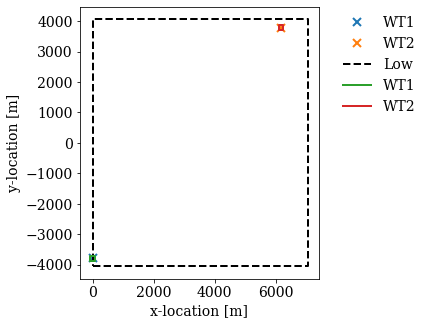

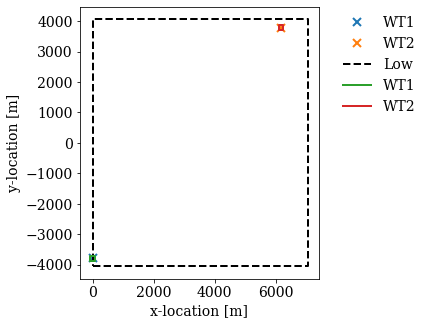

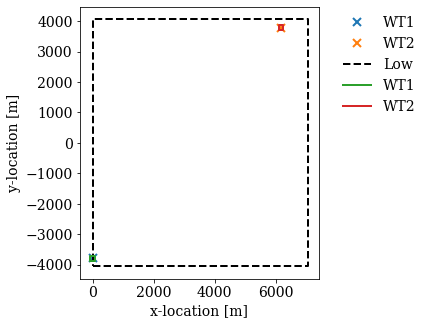

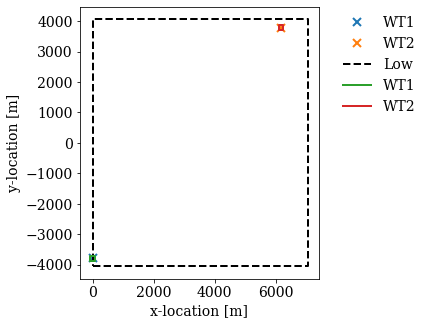

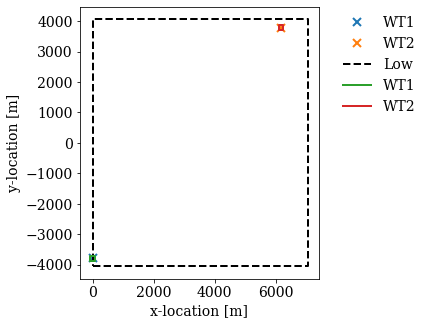

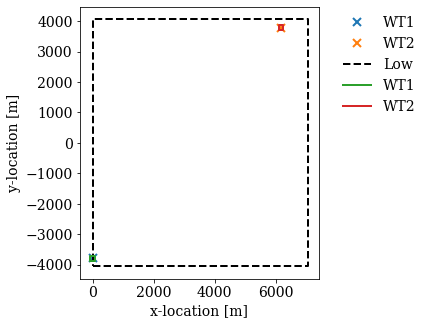

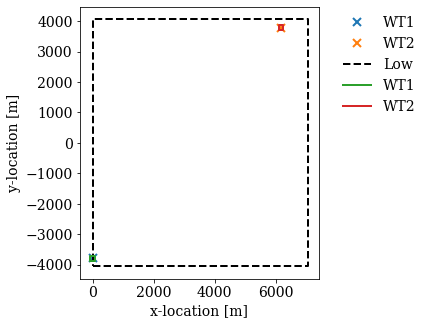

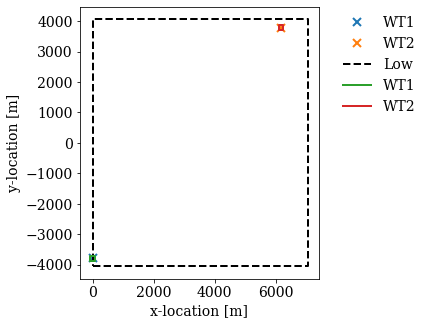

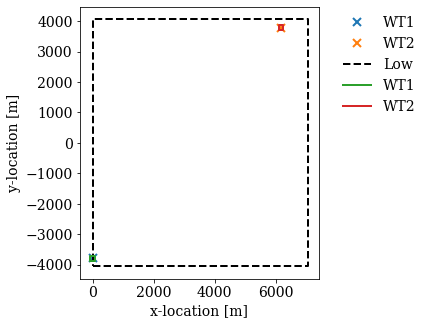

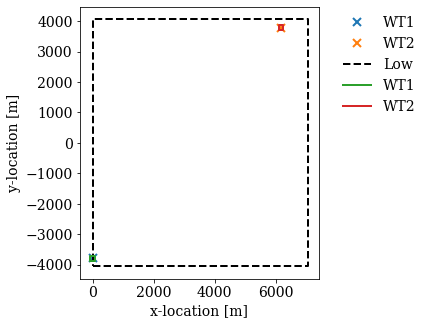

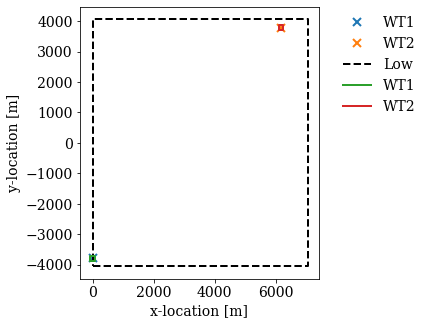

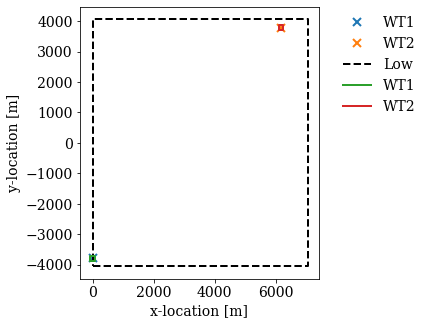

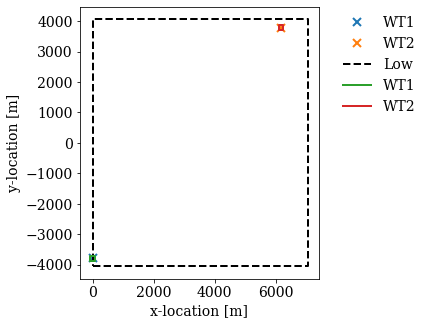

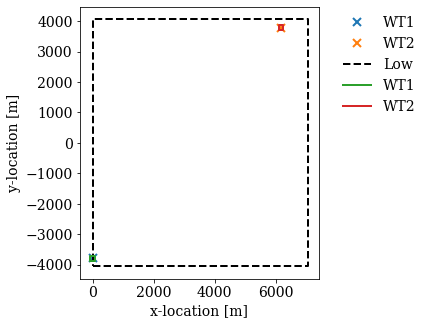

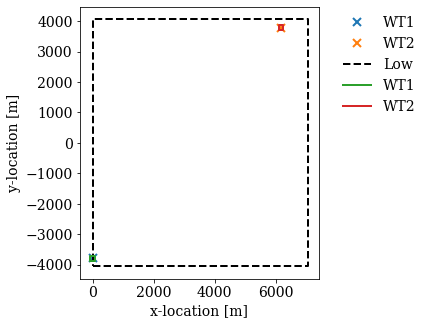

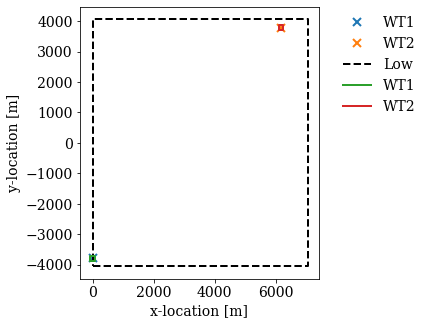

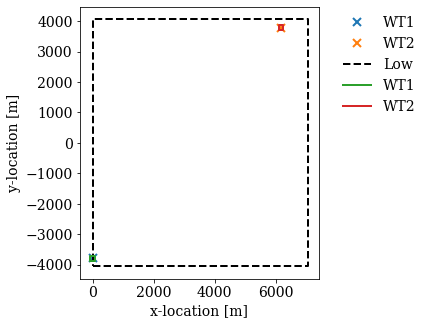

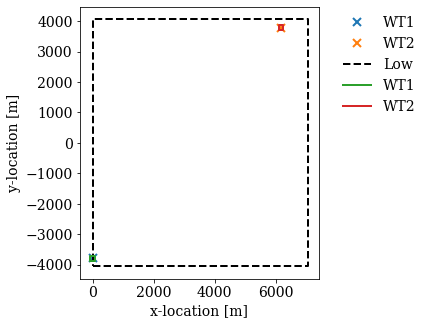

In [28]:
os.chdir(workdir)
print("Creating TurbSim files with the following parameters:")
print("caseNames:", caseNames)
print("nSeeds:", nSeeds)
print("ParamVals:", ParamVals)
print("D:", D)
print("HubHt:", HubHt)
print("t_benchmark:", t_benchmark)
print("t_step:", t_step)
print("fmax:", fmax)
cmax=19

#Full Duration case
createTSParamFiles(caseNames,nSeeds,ParamVals,D,HubHt,t_desired,t_step,fmax,cmax,'TSParams.txt')

#Benchmark case (copies Case00 files to new folder called 'Benchmark')
os.chdir(workdir)
if not os.path.exists('Benchmark'):
    subprocess.call(["cp",'-a', 'Case00', 'Benchmark'])

### Run this benchmark TurbSim file to get an idea of total run duration
 *Warning - You may run out of memory if the domain is large*

In [29]:
seednames = ['Seed_' + str(n) for n in range(0,1)]

filenames_list = []
(_, folders, _) = next(walk('./'))
foldernames = [fn for fn in folders if fn.startswith("Case")]
for folder in ['Benchmark']:
    for seedname in ['Seed_0']:
        dirname = ''+folder+'/'+seedname+'/TurbSim/'
        print(dirname)
        (_, dirnames , filenames) = next(walk(dirname))
        filenames = [dirname+fi for fi in filenames if fi.endswith("Low.inp")]
        filenames_list.append(filenames)

filenames_list = list(itertools.chain(*filenames_list))

print(os.getcwd())
for input_file in filenames_list:
    subprocess.call(["../../../build/modules/turbsim/turbsim", input_file])

Benchmark/Seed_0/TurbSim/
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm


### Plot the BTS files after they are created

Opening file Low.bts...
fPath in readBTS Low.bts
Opening file Low.bts...


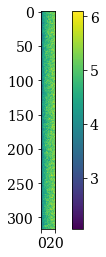

In [30]:
import stochasticTurbulenceTools_mod

new_bts = stochasticTurbulence(100, 'Low')
new_bts.readBTSHead('',88)
new_bts.readBTS('',88)
new_bts.visualize(component='u',time=9)

## You are now ready to run TurbSim simulations to create the low-resolution domains. You can not yet create the high-resolution domains!!

### Once the low-resolution simulations are complete, you are ready to finish generating the input files required for the high-resolution TurbSim domains, and you can move on to the next step.

## The following command creates the User-specified time series files that are required to finish generating the high-resolution TurbSim domains. This step will extract the time series from the .bts file from the low-resolution domain at each of the turbine locations and write them out into .txt files.

In [31]:
def writeTimeSeriesFile(fileOut,yloc,zloc,u,v,w,time):
    import math
    """ Write a TurbSim primary input file, 

    """

    print('Writing {0}'.format(fileOut))
    # --- Writing TurbSim user-defined time series file
    with open(fileOut, 'w') as f:
        f.write('--------------TurbSim v2.00.* User Time Series Input File-----------------------\n')
        f.write('     Time series input from Experimental Data\n')
        f.write('--------------------------------------------------------------------------------\n')
        f.write('          3 nComp - Number of velocity components in the file\n')
        f.write('          1 nPoints - Number of time series points contained in this file (-)\n')
        f.write('          1 RefPtID - Index of the reference point (1-nPoints)\n')
        f.write('     Pointyi Pointzi ! nPoints listed in order of increasing height\n')
        f.write('       (m)     (m)\n')
        f.write('       {0}   {1}\n'.format(yloc,zloc))
        f.write('--------Time Series-------------------------------------------------------------\n')
        f.write('Elapsed Time            Point01u                Point01v                Point01w\n')
        f.write('       (s)             (m/s)                   (m/s)                   (m/s)\n')
        for i in range(time.shape[0]):
            f.write('{:.2f}\t{:.5f}\t{:.5f}\t{:.5f}\n'.format(time[i],u[i],v[i],w[i]))

In [36]:
nSeeds=5
#
# for case in range(nCases):
#     name1=caseNames[case]
#     if not os.path.exists(name1):
#         os.makedirs(name1)
#     os.chdir(name1)
#     print(os.getcwd())
#     copyNominalFiles(nSeeds,nTurbs)
#     os.chdir('..')
# os.chdir(workdir)
#
os.chdir(workdir)
yloc = 0.0
zloc = HubHt
# for case in range(nCases):#caseNames:
for case in range(nCases):
    name1=caseNames[case]
    xlocs=['None']*nTurbs
    ylocs=['None']*nTurbs
    for wt in range(nTurbs):
        xlocs[wt]=float(ParamVals[case][3+wt*2])
        ylocs[wt]=float(ParamVals[case][4+wt*2])
        
    for seed in range(nSeeds):
#         abspath = '/home/kshaler/python-toolbox/pyFAST/fastfarm/FFarmSetup/{0}/Seed_{1}/TurbSim/'.format(case,seed)
        abspath = workdir+'/{0}/Seed_{1}/TurbSim/'.format(case,seed)
#         abspath = workdir+'/FFarmSetup/{0}/Seed_{1}/TurbSim/'.format(case,seed)
        
        TSpathLow  = abspath+'Low'
        print(TSpathLow)
        IFdata = stochasticTurbulence(D,prefix=TSpathLow)
        IFdata.readBTS('.',HubHt)
        meanu = IFdata.u[:,IFdata.jHub,IFdata.kHub].mean()
        Width = IFdata.dY*(IFdata.nY-1)
        lowTime = np.arange(0, IFdata.nSeconds, IFdata.dT)
        
        for wt in range(nTurbs):
            tstart=int(xlocs[wt]/meanu/IFdata.dT+3.0*D) ## This 3D is based on the default in this scripts to start the FFarm domain 3D upstream of the most upstream turbine. Modify if needed

            tmp = lowTime.shape[0]-tstart

            TurbLoc_rel=ylocs[wt]+Width/2.

            fileOut = abspath+'USRTimeSeries_T{0}.txt'.format(wt)

            uvel = np.zeros(lowTime.shape[0])
            vvel = np.zeros(lowTime.shape[0])
            wvel = np.zeros(lowTime.shape[0])

            uvel[:tmp] = IFdata.u[tstart:,IFdata.y2j(TurbLoc_rel),IFdata.kHub]
            vvel[:tmp] = IFdata.v[tstart:,IFdata.y2j(TurbLoc_rel),IFdata.kHub]
            wvel[:tmp] = IFdata.w[tstart:,IFdata.y2j(TurbLoc_rel),IFdata.kHub]

            uvel[tmp:] = IFdata.u[:tstart,IFdata.y2j(TurbLoc_rel),IFdata.kHub]
            vvel[tmp:] = IFdata.v[:tstart,IFdata.y2j(TurbLoc_rel),IFdata.kHub]
            wvel[tmp:] = IFdata.w[:tstart,IFdata.y2j(TurbLoc_rel),IFdata.kHub]


            writeTimeSeriesFile(fileOut,yloc,zloc,uvel,vvel,wvel,lowTime)

KeyError: 0

### You are now ready to run TurbSim for each of your high-res domains!
### Once those domains are created, you are ready for the final step of creating the FAST.Farm input (.fstf) input file

In [33]:
os.getcwd()
os.chdir(workdir)
os.getcwd()

'/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm'

In [34]:
createFFParamFiles(caseNames,nSeeds,ParamVals,HubHt,D,'FFarmParams.txt')

nTurbs: 2
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00
fPath in readBTS Seed_0/TurbSim/Low.bts
Opening file Seed_0/TurbSim/Low.bts...
fPath in readBTS Seed_0/TurbSim/Low.bts
Opening file Seed_0/TurbSim/Low.bts...
fPath in readBTS Seed_0/TurbSim/HighT1.bts
Opening file Seed_0/TurbSim/HighT1.bts...
/Users/abarker/Desktop/AWAKEN/FAST/openfast/python-toolbox/pyFAST/fastfarm/Case00/Seed_0
Writing FFarm input file:  FFarmParams.txt
xlocs[turb]: 0.15
xlocs[turb]: 0.0


SyntaxError: invalid syntax (FFarmCaseCreation.py, line 190)

In [ ]:
ParamVals[case]

# Now we will create the full length TurbSim parameter files, then the full-length Fast Farm files
#### Create the full-length TurbSim parameter files

In [ ]:
createTSParamFiles(caseNames,nSeeds,ParamVals,D,HubHt,t_desired,t_step,fmax,'TSParams.txt')

# Run each TurbSim Low Res Case

In [ ]:
seednames = ['Seed_' + str(n) for n in range(0,5)]

filenames_list = []
(_, folders, _) = next(walk('./'))
foldernames = [fn for fn in folders if fn.startswith("Case")]
for folder in foldernames:
    for seedname in seednames:
        dirname = ''+folder+'/'+seedname+'/TurbSim/'
        (_, dirnames , filenames) = next(walk(dirname))
        filenames = [dirname+fi for fi in filenames if fi.endswith("Low.inp")]
        filenames_list.append(filenames)

filenames_list = list(itertools.chain(*filenames_list))

print(os.getcwd())
for input_file in filenames_list:
    subprocess.call(["../../../build/modules/turbsim/turbsim", input_file])